In [1]:
!pip install gymnasium
!pip install pettingzoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
thinc 8.0.17 requires typing-extensions<4.2.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.5.0 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.5.0 which is incompatible.
tensorflow-transform 1.

In [2]:
import os
import pandas as pd
import numpy as np

In [3]:
import functools

import copy

import gymnasium
import numpy as np
from gymnasium.spaces import Discrete, Box, Sequence

from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector, wrappers

from enum import Enum
import random

import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
SIMULATION_LENGTH = 2000

NOOP = 6
SEND_TO_REMOTE = 5
MOVES = [0, 1, 2, 3, 4, SEND_TO_REMOTE, NOOP]

In [5]:
class MachineState(Enum):
    FREE = 0
    LOW = 1
    MED = 2
    HIGH = 3

# Reward and job definitions:
# 3 different job types: Low, Medium, High (L jobs are shorter, and H jobs take longer)
alpha_L, alpha_M, alpha_H = 0.7, 0.3, 0.1 # Probability of a job completing at any particular timestep
R_L, R_M, R_H = 20, 50, 80 # Rewards for each job type

machine_state_to_alpha_mapping = {
    MachineState.LOW: alpha_L,
    MachineState.MED: alpha_M,
    MachineState.HIGH: alpha_H
}

machine_state_to_reward_mapping = {
    MachineState.LOW: R_L,
    MachineState.MED: R_M,
    MachineState.HIGH: R_H
}
    


In [6]:

def make_env(render_mode=None):
    """
    The env function often wraps the environment in wrappers by default.
    You can find full documentation for these methods
    elsewhere in the developer documentation.
    """
    internal_render_mode = render_mode if render_mode != "ansi" else "human"
    env = raw_env(render_mode=internal_render_mode)
    # This wrapper is only for environments which print results to the terminal
    if render_mode == "ansi":
        env = wrappers.CaptureStdoutWrapper(env)
    # this wrapper helps error handling for discrete action spaces
#     env = wrappers.AssertOutOfBoundsWrapper(env) # Do we need this anymore? It causes errors...
    # Provides a wide vareity of helpful user errors
    # Strongly recommended
    env = wrappers.OrderEnforcingWrapper(env)
    return env


class raw_env(AECEnv):
    ##### Helper Functions #####
    def _generate_workload(self):
        # Equal chance of generating a Low, Medium or High job, or no job
        population = [MachineState.LOW, MachineState.MED, MachineState.HIGH, MachineState.FREE]
        weights = [0.25, 0.25, 0.25, 0]
        return random.choices(population=population, weights=weights)[0]
    
    ##### Environment Definitions #####
    """
    The metadata holds environment constants. From gymnasium, we inherit the "render_modes",
    metadata which specifies which modes can be put into the render() method.
    At least human mode should be supported.
    The "name" metadata allows the environment to be pretty printed.
    """
    metadata = {"render_modes": ["human"], "name": "dmrs_v0"}

    def __init__(self, render_mode=None):
        """
        The init method takes in environment arguments and
         should define the following attributes:
        - possible_agents
        - action_spaces
        - observation_spaces
        These attributes should not be changed after initialization.
        """
        self.possible_agents = ["datacentre_" + str(r) for r in range(2)]
        self.agent_name_mapping = dict(
            zip(self.possible_agents, list(range(len(self.possible_agents))))
        )
        # Encodes the entire system state. All machines start off as free. Status is either a job of type {job_status, datacentre, reward}, or FREE.
        self.machine_states = [[MachineState.FREE for _ in range(5)] for _ in range(2)]
        # Encodes the list of jobs arriving at all timesteps. Each job is a dict of {job_status, datacentre, reward}.
        self.job_queues = [
            [[] for _ in range(2)] for _ in range(SIMULATION_LENGTH)
        ]

        # Allocate to 5 machines, allocate to remote, NOOP
        self._action_spaces = { agent: Sequence(Discrete(5 + 1 + 1)) for agent in self.possible_agents } # Is this needed?

        # 5 machines, workload, workload_reward
        single_agent_observation_space = Box(low=-100, high=100, dtype=np.int32, shape=(5 + 1 + 1, )) # This is wrong now!
        self._observation_spaces = { agent: single_agent_observation_space for agent in self.possible_agents } # This is wrong now!
        self.render_mode = render_mode

    # this cache ensures that same space object is returned for the same agent
    # allows action space seeding to work as expected
    @functools.lru_cache(maxsize=None)
    def observation_space(self, agent):
        # 5 machines, workload, workload_reward
        return Box(low=-100, high=100, dtype=np.int32, shape=(5 + 1 + 1, )) # This is wrong now!

    @functools.lru_cache(maxsize=None)
    def action_space(self, agent):
        # Allocate to 5 machines, allocate to remote, NOOP for each action per job
        job_queue = self._get_state[agent]['job_queue']
        return MultiDiscrete(np.array([7 for _ in range(len(job_queue))]))

    def render(self):
        """
        Renders the environment. In human mode, it can print to terminal, open
        up a graphical window, or open up some other display that a human can see and understand.
        """
        if self.render_mode is None:
            gymnasium.logger.warn(
                "You are calling render method without specifying any render mode."
            )
            return

        if len(self.agents) == 2:
            state = self._get_state()
            string = f"Current state: datacentre_0: {state[self.agents[0]]} , datacentre_1: {state[self.agents[1]]}"
        else:
            string = "Game over"
        print(string)

    def close(self):
        """
        Close should release any graphical displays, subprocesses, network connections
        or any other environment data which should not be kept around after the
        user is no longer using the environment.
        """
        pass
    
    def _get_remote_datacentre(self, agent, _action=None):
        """
        Returns the remote data centre associated with the action the given agent picked
        _action is currently unused as the environment only has 2 agents and hence is simple
        """
        assert agent in self.agents
        if agent == 'datacentre_0':
            return 'datacentre_1'
        else:
            return 'datacentre_0'
    
    def observe(self, agent):
        """
        Observe should return the observation of the specified agent. This function
        should return a sane observation (though not necessarily the most up to date possible)
        at any time after reset() is called.
        """
        return self.observations[agent]
    
    def _get_state(self):
        # machine_states: 0 if free, 1 if occupied
        # job_queue: list of jobs
        state = {
            agent: {
                "machine_states": [0 if machine_state == MachineState.FREE else 1 for machine_state in self.machine_states[self.agent_name_mapping[agent]]],
                "job_queue": self.job_queues[self.curr_timestep][self.agent_name_mapping[agent]]
            } for agent in self.agents
        }
        return state

    def reset(self, seed=None, return_info=False, options=None):
        """
        Reset needs to initialize the following attributes
        - agents
        - rewards
        - _cumulative_rewards
        - terminations
        - truncations
        - infos
        - agent_selection
        And must set up the environment so that render(), step(), and observe()
        can be called without issues.
        Here it sets up the state dictionary which is used by step() and the observations dictionary which is used by step() and observe()
        """
        # Encodes the entire system state. All machines start off as free. Status is either a job of type {job_status, datacentre, reward}, or FREE.
        self.machine_states = [[MachineState.FREE for _ in range(5)] for _ in range(2)]
        # Encodes the list of jobs arriving at all timesteps. Each job is a dict of {job_status, datacentre, reward}.
        self.job_queues = [
            [[] for _ in range(2)] for _ in range(SIMULATION_LENGTH)
        ]
        self.curr_timestep = 0
        self.agents = self.possible_agents[:]
        self.rewards = {agent: 0 for agent in self.agents}
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self.actions = {agent: [] for agent in self.agents}
        
        # Try and generate a job for each data centre
        for agent in self.agents:
            agent_num = self.agent_name_mapping[agent]
            new_job = self._generate_workload()
            if new_job != MachineState.FREE:
                self.job_queues[self.curr_timestep][agent_num].append({'job_status': new_job, 'datacentre': agent, 'reward': machine_state_to_reward_mapping[new_job]})
        
        self.observations = self._get_state()
                
        """
        Our agent_selector utility allows easy cyclic stepping through the agents list.
        """
        self._agent_selector = agent_selector(self.agents)
        self.agent_selection = self._agent_selector.next()

    def step(self, action):
        """
        step(action) takes in an action for the current agent (specified by
        agent_selection) and needs to update
        - rewards
        - _cumulative_rewards (accumulating the rewards)
        - terminations
        - truncations
        - infos
        - agent_selection (to the next agent)
        And any internal state used by observe() or render()
        """
        if (
            self.terminations[self.agent_selection]
            or self.truncations[self.agent_selection]
        ):
            # handles stepping an agent which is already dead
            # accepts a None action for the one agent, and moves the agent_selection to
            # the next dead agent,  or if there are no more dead agents, to the next live agent
            self._was_dead_step(action)
            return

        agent = self.agent_selection
        
        # If the agent is first, we should reset all state for a clean observation this time step
        if self._agent_selector.is_first():
            self.actions = {agent: [] for agent in self.agents}

            # no rewards are allocated until both players give an action
            self._clear_rewards()

        # the agent which stepped last had its _cumulative_rewards accounted for
        # (because it was returned by last()), so the _cumulative_rewards for this
        # agent should start again at 0
        self._cumulative_rewards[agent] = 0

        # stores action of current agent
        self.actions[agent] = action # action is a list of actions for each job in the job queue

        # collect reward if it is the last agent to act
        if self._agent_selector.is_last():
            self.rewards['datacentre_0'] = 0
            self.rewards['datacentre_1'] = 0
            
            # Process actions for each agent:
            for agent in self.agents:
                for action, job in zip(self.actions[agent], self.observe(agent)['job_queue']):
                    if action == NOOP:
                        continue
                    if action == SEND_TO_REMOTE: # Send to remote
                        remote_datacentre = self._get_remote_datacentre(agent)
                        remote_datacentre_num = self.agent_name_mapping[remote_datacentre]
                        if self.curr_timestep + 1 < len(self.job_queues):
                            self.job_queues[self.curr_timestep + 1][remote_datacentre_num].append({'job_status': job['job_status'], 'datacentre': job['datacentre'], 'reward': job['reward'] - 10})
                    else: # Allocate to a local machine
                        agent_num = self.agent_name_mapping[agent]
                        machine_num = action
                        if self.machine_states[agent_num][machine_num] == MachineState.FREE:
                            self.machine_states[agent_num][machine_num] = job # Store whole job dict in machine state
                            self.rewards[job['datacentre']] += 5 # send reward for allocating the job to the original data centre
                        else:
                            self.rewards[job['datacentre']] -= 10 # penalize the original data centre #(Maybe this is something to think about later?)
                            
            # Workloads are completed based on their alpha values:
            for agent in self.agents:
                agent_num = self.agent_name_mapping[agent]
                for machine_num, workload in enumerate(self.machine_states[agent_num]): # [{'job_status': HIGH, 'datacentre': datacentre_0, 'reward': 40}, FREE, ...]
                    if workload != MachineState.FREE:
                        alpha = machine_state_to_alpha_mapping[workload['job_status']]
                        if random.random() < alpha:
                            self.machine_states[agent_num][machine_num] = MachineState.FREE
                            self.rewards[workload['datacentre']] += workload['reward']
                            
            
#             # TODO: Calculate rewards for all agents. Placeholder:
#             self.rewards[self.agents[0]] = 1
#             self.rewards[self.agents[1]] = 2
            
            # The truncations dictionary must be updated for all players.
            self.truncations = {
                agent: self.curr_timestep >= SIMULATION_LENGTH for agent in self.agents
            }
            
            self.curr_timestep += 1
            if self.curr_timestep < SIMULATION_LENGTH:
                # Observations at the start of the next timestep
                self.observations = self._get_state()
                
                # Try and generate a job for each data centre for the coming timestep
                for agent in self.agents:
                    agent_num = self.agent_name_mapping[agent]
                    new_job = self._generate_workload()
                    if new_job != MachineState.FREE:
                        self.job_queues[self.curr_timestep][agent_num].append({'job_status': new_job, 'datacentre': agent, 'reward': machine_state_to_reward_mapping[new_job]})
            
                

        # selects the next agent.
        self.agent_selection = self._agent_selector.next()
        # Adds .rewards to ._cumulative_rewards
        self._accumulate_rewards() # Not even sure if I need this

        if self.render_mode == "human":
            self.render()

print("Loaded environment")

Loaded environment


In [7]:
def random_policy(agent, state_observation, job):
    return np.random.randint(5 + 1 + 1)

In [8]:
NUM_EPISODES = 50

env = make_env()

steps_done = 0

episode_returns = {
    "datacentre_0": [],
    "datacentre_1": []
}

for i_episode in range(NUM_EPISODES):
    if (i_episode+1) % 10 == 0:
        print("=====> episode ", i_episode+1, "/", NUM_EPISODES)
    env.reset()
    _observation, _reward, termination, truncation, _info = env.last()
    
    # Run an episode
    actions_taken = {
        "datacentre_0": None,
        "datacentre_1": None
    }
    state_observations = {
        "datacentre_0": env.observe("datacentre_0"),
        "datacentre_1": env.observe("datacentre_1")
    }
    rets = {
        "datacentre_0": 0,
        "datacentre_1": 0
    }
    for agent in env.agent_iter():
#         if env.env.curr_timestep % 500 == 0:
#             print(f"Timestep: {env.env.curr_timestep}")
            
        if termination or truncation:
            env.step(None)
            continue
        
        # Use the policy to get an action for each job in the job queue
        job_queue = state_observations[agent]['job_queue']
        actions = [NOOP for _ in range(len(job_queue))]
        for i, job in enumerate(job_queue):
            actions[i] = action = random_policy(agent, state_observations[agent]['machine_states'], job)
#         print(f"{agent} is taking actions {actions} for job queue {job_queue}")
        actions_taken[agent] = actions
        env.step(actions)
        
        _observation, _reward, termination, truncation, _info = env.last()


        if agent == "datacentre_1":
#             print(f"Finished one step, now at timestep {env.env.curr_timestep}") # Should have advanced to the next timestep (t)
            
            rets['datacentre_0'] += env.rewards['datacentre_0']
            rets['datacentre_1'] += env.rewards['datacentre_1']
            
            # TODO: Update agents' policies
#             print(f"Rewards (t-1): {env.rewards}")
#             print(f"Actions taken (t-1): {actions_taken}")
#             print(f"State Observations (t-1): {state_observations}") # previous state
            new_state_observations = {
                "datacentre_0": env.observe("datacentre_0"),
                "datacentre_1": env.observe("datacentre_1")
            }
#             print(f"State Observations (t): {new_state_observations}")
            # state_observations + actions_taken + rewards => update policy with these 
            
            # Advance state
            state_observations = new_state_observations
            # Reset actions taken
            actions_taken = {
                "datacentre_0": None,
                "datacentre_1": None
            }

#             print()
            
    episode_returns['datacentre_0'].append(rets['datacentre_0'])
    episode_returns['datacentre_1'].append(rets['datacentre_1'])

print("Done!")

=====> episode  10 / 50
=====> episode  20 / 50
=====> episode  30 / 50
=====> episode  40 / 50
=====> episode  50 / 50
Done!


Episode Returns:
{'datacentre_0': [43965, 44640, 46490, 45280, 44925, 44615, 47480, 48045, 45785, 45470, 47755, 45990, 45790, 46535, 47285, 45295, 42780, 46725, 46230, 46370, 48190, 44105, 46530, 46750, 45135, 47670, 44810, 45710, 48850, 46915, 45780, 47410, 44870, 45685, 45215, 47160, 45675, 48520, 46415, 46865, 45095, 43745, 46260, 45090, 45510, 45695, 45560, 47480, 44600, 45785], 'datacentre_1': [49920, 44905, 48190, 46675, 43170, 45950, 46895, 45035, 44165, 48185, 48170, 42635, 49480, 46600, 47360, 45390, 49500, 45840, 44905, 46895, 47380, 46610, 46655, 46355, 47495, 45650, 47550, 44235, 47380, 47605, 46565, 45680, 45615, 44635, 48690, 47945, 44030, 46660, 49260, 45675, 45075, 45295, 44380, 48025, 47540, 44085, 46040, 43710, 47880, 47015]}

Total System Reward:
[93885 89545 94680 91955 88095 90565 94375 93080 89950 93655 95925 88625
 95270 93135 94645 90685 92280 92565 91135 93265 95570 90715 93185 93105
 92630 93320 92360 89945 96230 94520 92345 93090 90485 90320 93905 95105
 8970

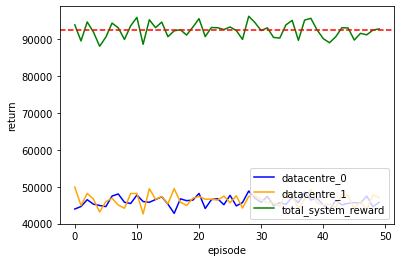

In [9]:
print("Episode Returns:")
print(episode_returns)
print()

total_system_reward = np.array(episode_returns['datacentre_0']) + np.array(episode_returns['datacentre_1'])
total_system_reward_mean = np.mean(total_system_reward)
print("Total System Reward:")
print(total_system_reward)
print("Mean:", total_system_reward_mean)
print()


plt.plot(torch.arange(NUM_EPISODES), episode_returns['datacentre_0'], label="datacentre_0", color='blue')
plt.ylabel("return")
plt.xlabel("episode")

plt.plot(torch.arange(NUM_EPISODES), episode_returns['datacentre_1'], label="datacentre_1", color='orange')
plt.ylabel("return")
plt.xlabel("episode")

plt.plot(torch.arange(NUM_EPISODES), total_system_reward, label="total_system_reward", color='green')
plt.ylabel("return")
plt.xlabel("episode")

plt.axhline(y=total_system_reward_mean, color='r', linestyle='--')

plt.legend(loc='lower right')
# plt.savefig(f'/kaggle/working/{filename}.png')
plt.show()

In [10]:
def greedy_policy(agent, state_observation, job):
    for machine_num, machine_state in enumerate(state_observation):
        if machine_state == 0:
            return machine_num
    return NOOP

In [11]:
NUM_EPISODES = 50

env = make_env()

steps_done = 0

episode_returns = {
    "datacentre_0": [],
    "datacentre_1": []
}

for i_episode in range(NUM_EPISODES):
    if (i_episode+1) % 10 == 0:
        print("=====> episode ", i_episode+1, "/", NUM_EPISODES)
    env.reset()
    _observation, _reward, termination, truncation, _info = env.last()
    
    # Run an episode
    actions_taken = {
        "datacentre_0": None,
        "datacentre_1": None
    }
    state_observations = {
        "datacentre_0": env.observe("datacentre_0"),
        "datacentre_1": env.observe("datacentre_1")
    }
    rets = {
        "datacentre_0": 0,
        "datacentre_1": 0
    }
    for agent in env.agent_iter():
#         if env.env.curr_timestep % 500 == 0:
#             print(f"Timestep: {env.env.curr_timestep}")
            
        if termination or truncation:
            env.step(None)
            continue
        
        # Use the policy to get an action for each job in the job queue
        job_queue = state_observations[agent]['job_queue']
        actions = [NOOP for _ in range(len(job_queue))]
        for i, job in enumerate(job_queue):
            actions[i] = action = greedy_policy(agent, state_observations[agent]['machine_states'], job)
#         print(f"{agent} is taking actions {actions} for job queue {job_queue}")
        actions_taken[agent] = actions
        env.step(actions)
        
        _observation, _reward, termination, truncation, _info = env.last()


        if agent == "datacentre_1":
#             print(f"Finished one step, now at timestep {env.env.curr_timestep}") # Should have advanced to the next timestep (t)
            
            rets['datacentre_0'] += env.rewards['datacentre_0']
            rets['datacentre_1'] += env.rewards['datacentre_1']
            
            # TODO: Update agents' policies
#             print(f"Rewards (t-1): {env.rewards}")
#             print(f"Actions taken (t-1): {actions_taken}")
#             print(f"State Observations (t-1): {state_observations}") # previous state
            new_state_observations = {
                "datacentre_0": env.observe("datacentre_0"),
                "datacentre_1": env.observe("datacentre_1")
            }
#             print(f"State Observations (t): {new_state_observations}")
            # state_observations + actions_taken + rewards => update policy with these 
            
            # Advance state
            state_observations = new_state_observations
            # Reset actions taken
            actions_taken = {
                "datacentre_0": None,
                "datacentre_1": None
            }

#             print()
            
    episode_returns['datacentre_0'].append(rets['datacentre_0'])
    episode_returns['datacentre_1'].append(rets['datacentre_1'])

print("Done!")

=====> episode  10 / 50
=====> episode  20 / 50
=====> episode  30 / 50
=====> episode  40 / 50
=====> episode  50 / 50
Done!


Episode Returns:
{'datacentre_0': [92860, 94005, 91470, 88930, 87360, 92210, 91795, 92440, 90725, 88580, 91335, 92105, 91065, 94065, 94470, 91585, 94635, 92905, 91465, 92775, 91590, 91020, 91935, 89375, 91955, 90315, 89775, 90740, 91125, 89185, 91075, 91725, 92620, 93020, 93695, 91385, 94045, 92400, 94330, 91140, 93925, 92125, 92920, 91800, 94120, 91260, 93865, 88195, 90440, 90700], 'datacentre_1': [92050, 92360, 93725, 91765, 92455, 93825, 89820, 88715, 92150, 92695, 94500, 94085, 90790, 90565, 90580, 95135, 95845, 92000, 90955, 92230, 88100, 92410, 93425, 94130, 92090, 91735, 90835, 92485, 89155, 95100, 90920, 91780, 91470, 90930, 93760, 91530, 91200, 93345, 89320, 92580, 94115, 92630, 91755, 92390, 94640, 93410, 91640, 90880, 90140, 93355]}

Total System Reward:
[184910 186365 185195 180695 179815 186035 181615 181155 182875 181275
 185835 186190 181855 184630 185050 186720 190480 184905 182420 185005
 179690 183430 185360 183505 184045 182050 180610 183225 180280 184285
 181995 183

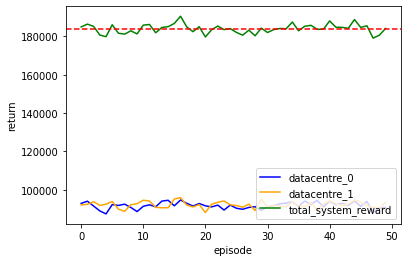

In [12]:
print("Episode Returns:")
print(episode_returns)
print()

total_system_reward = np.array(episode_returns['datacentre_0']) + np.array(episode_returns['datacentre_1'])
total_system_reward_mean = np.mean(total_system_reward)
print("Total System Reward:")
print(total_system_reward)
print("Mean:", total_system_reward_mean)
print()


plt.plot(torch.arange(NUM_EPISODES), episode_returns['datacentre_0'], label="datacentre_0", color='blue')
plt.ylabel("return")
plt.xlabel("episode")

plt.plot(torch.arange(NUM_EPISODES), episode_returns['datacentre_1'], label="datacentre_1", color='orange')
plt.ylabel("return")
plt.xlabel("episode")

plt.plot(torch.arange(NUM_EPISODES), total_system_reward, label="total_system_reward", color='green')
plt.ylabel("return")
plt.xlabel("episode")

plt.axhline(y=total_system_reward_mean, color='r', linestyle='--')

plt.legend(loc='lower right')
# plt.savefig(f'/kaggle/working/{filename}.png')
plt.show()

=> Now try with reinforcement learning:

In [13]:
import random
from collections import deque

import torch
import torch.nn.functional as F
from gymnasium.core import Env
from torch import nn

class ReplayBuffer():
    def __init__(self, size:int, early_transitions_buffer_percentage:int = 0.1):
        """Replay buffer initialisation

        Args:
            size: maximum numbers of objects stored by replay buffer
        """
        self.size = size
        self.early_transitions_buffer_percentage = early_transitions_buffer_percentage
        self.early_transitions_buffer_size = int(early_transitions_buffer_percentage * size)
        # Reserve part of the buffer (default 10%) separate; do not overwrite any transitions here once filled
        self.early_transitions_buffer = deque([], self.early_transitions_buffer_size)
        self.rest_buffer_size = size - self.early_transitions_buffer_size
        self.rest_buffer = deque([], self.rest_buffer_size)
    
    def get_curr_size(self):
        return len(self.early_transitions_buffer) + len(self.rest_buffer)

    
    def push(self, transition):
        """Push an object to the replay buffer

        Args:
            transition: object to be stored in replay buffer. Can be of any type
        
        Returns:
            The current memory of the buffer (any iterable object e.g. list)
        """
        # Fill up the early_transitions_buffer until it is full
        if len(self.early_transitions_buffer) < self.early_transitions_buffer_size:
            self.early_transitions_buffer.append(transition)
        # If the early_transitions_buffer is full, we use the rest_buffer as usual
        else:
            self.rest_buffer.append(transition)
        return list(self.early_transitions_buffer) + list(self.rest_buffer)

    def sample(self, batch_size:int):
        """Get a random sample from the replay buffer
        
        Args:
            batch_size: size of sample

        Returns:
            iterable (e.g. list) with objects sampled from buffer without replacement
        """
        # Return a random sample from both buffers combined
        return random.sample(list(self.early_transitions_buffer) + list(self.rest_buffer), batch_size)


class DQN(nn.Module):
    def __init__(self, layer_sizes):
        """
        DQN initialisation

        Args:
            layer_sizes: list with size of each layer as elements
        """
        super(DQN, self).__init__()
        # torch.manual_seed(14597905165985114927) - This is a bad seed for a network of [4, 256, 2]
        self.layers = nn.ModuleList([nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-1)])
    
    def forward (self, x:torch.Tensor)->torch.Tensor:
        """Forward pass through the DQN

        Args:
            x: input to the DQN
        
        Returns:
            outputted value by the DQN
        """
        for layer in self.layers:
            x = F.leaky_relu(layer(x))
        return x

def greedy_action(dqn:DQN, state:torch.Tensor)->int:
    """Select action according to a given DQN
    
    Args:
        dqn: the DQN that selects the action
        state: state at which the action is chosen

    Returns:
        Greedy action according to DQN
    """
    return int(torch.argmax(dqn(state)))

def epsilon_greedy(epsilon:float, dqn:DQN, state:torch.Tensor)->int:
    """Sample an epsilon-greedy action according to a given DQN
    
    Args:
        epsilon: parameter for epsilon-greedy action selection
        dqn: the DQN that selects the action
        state: state at which the action is chosen
    
    Returns:
        Sampled epsilon-greedy action
    """
    q_values = dqn(state)
    num_actions = q_values.shape[0]
    greedy_act = int(torch.argmax(q_values))
    p = float(torch.rand(1))
    if p>epsilon:
        return greedy_act
    else:
        return random.randint(0,num_actions-1)

def update_target(target_dqn:DQN, policy_dqn:DQN):
    """Update target network parameters using policy network.
    Does not return anything but modifies the target network passed as parameter
    
    Args:
        target_dqn: target network to be modified in-place
        policy_dqn: the DQN that selects the action
    """

    target_dqn.load_state_dict(policy_dqn.state_dict())

def loss(policy_dqn:DQN, target_dqn:DQN,
         states:torch.Tensor, actions:torch.Tensor,
         rewards:torch.Tensor, next_states:torch.Tensor, dones:torch.Tensor, ddqn = False)->torch.Tensor:
    """Calculate Bellman error loss
    
    Args:
        policy_dqn: policy DQN
        target_dqn: target DQN
        states: batched state tensor
        actions: batched action tensor
        rewards: batched rewards tensor
        next_states: batched next states tensor
        dones: batched Boolean tensor, True when episode terminates
    
    Returns:
        Float scalar tensor with loss value
    """
    if ddqn:
        # DDQN Start:
        # torch.Size([BATCH_SIZE, 1])
        policy_dqn_best_action_batch = torch.argmax(policy_dqn(next_states), dim=1).reshape(-1, 1) # select best actions based on policy dqn
        # torch.Size([BATCH_SIZE, 2])
        target_dqn_next_states = target_dqn(next_states)
        # torch.Size([BATCH_SIZE, 1])
        selected_action_batch = target_dqn_next_states.gather(dim=1, index=policy_dqn_best_action_batch) # use actions on the target dqn

        # dones shape: torch.Size([BATCH_SIZE, 1]), reshaped(-1): torch.Size.([BATCH_SIZE])
        # rewards shape: torch.Size([BATCH_SIZE, 1]), reshaped(-1): torch.Size([BATCH_SIZE])
        # selected_action_batch reshaped(-1): torch.Size([BATCH_SIZE])
        # bellman_targets shape: torch.Size([BATCH_SIZE])
        bellman_targets = (~dones).reshape(-1)*(selected_action_batch).reshape(-1) + rewards.reshape(-1)
        # DDQN End
    else:
        bellman_targets = (~dones).reshape(-1)*(target_dqn(next_states)).max(1).values + rewards.reshape(-1)

    q_values = policy_dqn(states).gather(1, actions).reshape(-1)
    return ((q_values - bellman_targets)**2).mean()

print("Loaded utils")

Loaded utils


In [14]:
job_status_encoding = {
    MachineState.LOW: [0, 0, 1],
    MachineState.MED: [0, 1, 0],
    MachineState.HIGH: [1, 0, 0]
}

def rl_policy(EPSILON, policy_nets, state_observations, agent, job):
    flattened_observation = np.concatenate((
                                            np.array(state_observations[agent]['machine_states']),
                                            np.array(job_status_encoding[job['job_status']]),
                                            np.array([job['reward'] / 100])
                                          ))
    state = torch.tensor(flattened_observation).float()

    action = epsilon_greedy(EPSILON, policy_nets[agent], state)
    return action

In [15]:
def plot_graph_individual(ddqn_runs_results, NUM_EPISODES, filename):
    # Plot datacentre_0
    ddqn_results_dc0 = torch.tensor([run_result['datacentre_0'] for run_result in ddqn_runs_results])
    ddqn_means_dc0 = ddqn_results_dc0.float().mean(0)
    ddqn_stds_dc0 = ddqn_results_dc0.float().std(0)

    plt.plot(torch.arange(NUM_EPISODES), ddqn_means_dc0, label="DDQN Mean (datacentre_0)", color='blue')
    plt.ylabel("return")
    plt.xlabel("episode")
    plt.fill_between(np.arange(NUM_EPISODES), ddqn_means_dc0 + ddqn_stds_dc0, ddqn_means_dc0 - ddqn_stds_dc0, alpha=0.3, label=f"DDQN Mean ± Std (datacentre_0)", color='blue')
    
    # Plot datacentre_1
    ddqn_results_dc1 = torch.tensor([run_result['datacentre_1'] for run_result in ddqn_runs_results])
    ddqn_means_dc1 = ddqn_results_dc1.float().mean(0)
    ddqn_stds_dc1 = ddqn_results_dc1.float().std(0)

    plt.plot(torch.arange(NUM_EPISODES), ddqn_means_dc1, label="DDQN Mean (datacentre_1)", color='orange')
    plt.ylabel("return")
    plt.xlabel("episode")
    plt.fill_between(np.arange(NUM_EPISODES), ddqn_means_dc1 + ddqn_stds_dc1, ddqn_means_dc1 - ddqn_stds_dc1, alpha=0.3, label=f"DDQN Mean ± Std (datacentre_1)", color='orange')
    
    
    plt.legend(loc='lower right')
    plt.savefig(f'/kaggle/working/{filename}.png')
    plt.show()

def plot_graph_combined(ddqn_runs_results, NUM_EPISODES, filename):
    ddqn_runs_results_combined = torch.tensor(np.array([np.array(run_result['datacentre_0']) + np.array(run_result['datacentre_1']) for run_result in ddqn_runs_results]))
    ddqn_means = ddqn_runs_results_combined.float().mean(0)
    ddqn_stds = ddqn_runs_results_combined.float().std(0)

    plt.plot(torch.arange(NUM_EPISODES), ddqn_means, label="DDQN Mean (total system)", color='blue')
    plt.ylabel("return")
    plt.xlabel("episode")
    plt.fill_between(np.arange(NUM_EPISODES), ddqn_means + ddqn_stds, ddqn_means - ddqn_stds, alpha=0.3, label=f"DDQN Mean ± Std (total system)", color='blue')
    
    
    plt.legend(loc='lower right')
    plt.savefig(f'/kaggle/working/{filename}.png')
    plt.show()

print("Defined plot_graph")

Defined plot_graph


In [16]:
def run_experiment(
        NUM_RUNS = 1, 
        EPSILON_DECAY=0.97, 
        HIDDEN_LAYER=[512], 
        LEARNING_RATE = 0.01, 
        REPLAY_BUFFER_SIZE=30_000,
        NUM_EPISODES=300,
        REPLAY_BUFFER_MINIBATCH_SIZE=64,
        NETWORK_SYNC_FREQUENCY=50,
        ddqn=False
    ):
    print("DDQN:", ddqn)
    EPSILON_START = 1
    EPSILON_MIN = 0.001
    
    # Hyperparameters
    INPUT_LAYER_SIZE = 5 + 3 + 1 # 5 machines + job_status (one hot encoded, so 3 inputs) + job reward
    OUTPUT_LAYER_SIZE = 7 # 5 machines (1 action per machine) + send remote action + noop action 
    POLICY_NET_LAYER_SIZES = [INPUT_LAYER_SIZE] + HIDDEN_LAYER + [OUTPUT_LAYER_SIZE]
    TARGET_NET_LAYER_SIZES = [INPUT_LAYER_SIZE] + HIDDEN_LAYER + [OUTPUT_LAYER_SIZE]
    LEARNING_RATE = LEARNING_RATE
    REPLAY_BUFFER_SIZE = REPLAY_BUFFER_SIZE
    REPLAY_BUFFER_MINIBATCH_SIZE = REPLAY_BUFFER_MINIBATCH_SIZE
    NETWORK_SYNC_FREQUENCY = NETWORK_SYNC_FREQUENCY

    env = make_env()
    runs_results = []
    
    for run in range(NUM_RUNS):
        print(f"Starting run {run+1} of {NUM_RUNS}")
        policy_nets = {
            'datacentre_0': DQN(POLICY_NET_LAYER_SIZES),
            'datacentre_1': DQN(POLICY_NET_LAYER_SIZES)
        }
        target_nets = {
            'datacentre_0': DQN(POLICY_NET_LAYER_SIZES),
            'datacentre_1': DQN(POLICY_NET_LAYER_SIZES)
        }
        EPSILON = EPSILON_START
        update_target(target_nets['datacentre_0'], policy_nets['datacentre_0'])
        update_target(target_nets['datacentre_1'], policy_nets['datacentre_1'])
        target_nets['datacentre_0'].eval()
        target_nets['datacentre_1'].eval()
        
        optimizers = {
            'datacentre_0': optim.Adam(policy_nets['datacentre_0'].parameters(), lr=LEARNING_RATE),
            'datacentre_1': optim.Adam(policy_nets['datacentre_1'].parameters(), lr=LEARNING_RATE)
        }
            
        memorys = {
            'datacentre_0': ReplayBuffer(REPLAY_BUFFER_SIZE),
            'datacentre_1': ReplayBuffer(REPLAY_BUFFER_SIZE)
        }
    
        steps_done = 0

        episode_returns = {
            "datacentre_0": [],
            "datacentre_1": []
        }

        for i_episode in range(NUM_EPISODES):
            if (i_episode+1) % 10 == 0:
                print("=====> episode ", i_episode+1, "/", NUM_EPISODES)
            env.reset()
            _observation, _reward, termination, truncation, _info = env.last()

            # Run an episode
            actions_taken = {
                "datacentre_0": None,
                "datacentre_1": None
            }
            state_observations = {
                "datacentre_0": env.observe("datacentre_0"),
                "datacentre_1": env.observe("datacentre_1")
            }
            rets = {
                "datacentre_0": 0,
                "datacentre_1": 0
            }
            for agent in env.agent_iter():
        #         if env.env.curr_timestep % 500 == 0:
        #             print(f"Timestep: {env.env.curr_timestep}")

                if termination or truncation:
                    env.step(None)
                    continue

                # Use the policy to get an action for each job in the job queue
                job_queue = state_observations[agent]['job_queue']
                actions = [NOOP for _ in range(len(job_queue))]
                for i, job in enumerate(job_queue):
                    actions[i] = action = rl_policy(EPSILON, policy_nets, state_observations, agent, job)
        #         print(f"{agent} is taking actions {actions} for job queue {job_queue}")
                actions_taken[agent] = actions
                env.step(actions)

                _observation, _reward, termination, truncation, _info = env.last()

                if agent == "datacentre_1":
        #             print(f"Finished one step, now at timestep {env.env.curr_timestep}") # Should have advanced to the next timestep (t)

                    rets['datacentre_0'] += env.rewards['datacentre_0']
                    rets['datacentre_1'] += env.rewards['datacentre_1']
                
                    new_state_observations = {
                        "datacentre_0": env.observe("datacentre_0"),
                        "datacentre_1": env.observe("datacentre_1")
                    }
                    # Update agents' policies:
            #             print(f"Rewards (t-1): {env.rewards}")
            #             print(f"Actions taken (t-1): {actions_taken}")
            #             print(f"State Observations (t-1): {state_observations}") # previous state
                    for agent in ['datacentre_0', 'datacentre_1']:
                        job = state_observations[agent]['job_queue'][-1] # job sent to this agent is always the last job in the queue
                        state = np.concatenate((
                                                np.array(state_observations[agent]['machine_states']),
                                                np.array(job_status_encoding[job['job_status']]),
                                                np.array([job['reward'] / 100])
                                              ))
                        state = torch.tensor(state).float()

                        new_job = new_state_observations[agent]['job_queue'][-1] # job sent to this agent is always the last job in the queue
                        next_state = np.concatenate((
                                                    np.array(new_state_observations[agent]['machine_states']),
                                                    np.array(job_status_encoding[new_job['job_status']]),
                                                    np.array([new_job['reward'] / 100])
                                                   ))
                        next_state = torch.tensor(next_state).reshape(-1).float()
                        reward = torch.tensor([env.rewards[agent]])
                        action = torch.tensor([actions_taken[agent][-1]]) # Take the action corresponding to the last job in the queue
                        done = termination or truncation # Not sure about what done is for...
                            
                        memorys[agent].push([state, action, next_state, reward, torch.tensor([done])])

            #             print(f"State Observations (t): {new_state_observations}")
                    # state_observations + actions_taken + rewards => update policy with these 
                    # -- END FOR --
                    
                    # Advance state
                    state_observations = new_state_observations
                    # Reset actions taken
                    actions_taken = {
                        "datacentre_0": None,
                        "datacentre_1": None
                    }

        #             print()
                    steps_done += 1
                    # Perform one step of the optimization (on the policy network)
                    for agent in ['datacentre_0', 'datacentre_1']:
                        if not memorys[agent].get_curr_size() < REPLAY_BUFFER_MINIBATCH_SIZE:
                            transitions = memorys[agent].sample(REPLAY_BUFFER_MINIBATCH_SIZE)
                            state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in zip(*transitions))
                            # Compute loss
                            mse_loss = loss(policy_nets[agent], target_nets[agent], state_batch, action_batch, reward_batch, nextstate_batch, dones, ddqn=ddqn)
                            # Optimize the model
                            optimizers[agent].zero_grad()
                            mse_loss.backward()
                            optimizers[agent].step()
                        if steps_done % NETWORK_SYNC_FREQUENCY == 0:
                            update_target(target_nets[agent], policy_nets[agent])
                    # -- END FOR --
                # -- END IF --
            # -- END FOR --
            # Update epsilon
            EPSILON = max(EPSILON * EPSILON_DECAY, EPSILON_MIN)
            episode_returns['datacentre_0'].append(rets['datacentre_0'])
            episode_returns['datacentre_1'].append(rets['datacentre_1'])
        # -- END FOR --
        runs_results.append(episode_returns)
    # -- END FOR --
    print("Done!")
    return runs_results
# -- END FUNC --
print("Loaded run_experiment")

Loaded run_experiment


hidden layer: [512] LR: 0.001 eps decay: 0.985 minib size: 128 sync freq: 25000
DDQN: True
Starting run 1 of 1
Done!
--HLS_[512]_lr_0.001_epsdec_0.985_MBS_128_syncfreq_25000--
[{'datacentre_0': [47800, 48805], 'datacentre_1': [44650, 47560]}]


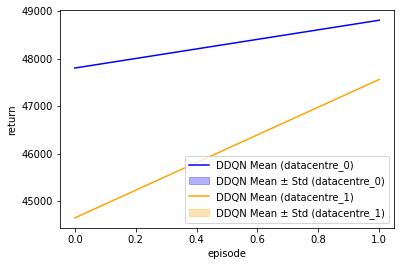

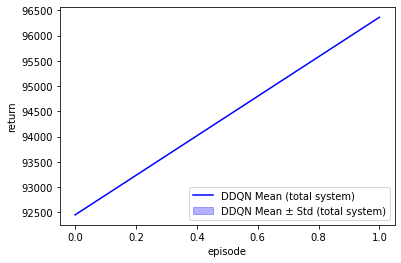

In [17]:
# Hyperparameter search
# hidden_layer_sizes = [128, 256, 512]
# learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]
# epsilon_decays = [0.999, 0.995, 0.99, 0.98, 0.97, 0.96]
# minibatch_sizes = [32, 64, 128, 256]
# network_sync_freqs = [50, 100, 200, 400]

hidden_layers = [[512]]
learning_rates = [0.001]
epsilon_decays = [0.985]
minibatch_sizes = [128]
network_sync_freqs = [25_000]

num_episodes = 2

for hidden_layer in hidden_layers:
    for learning_rate in learning_rates:
        for epsilon_decay in epsilon_decays:
            for minibatch_size in minibatch_sizes:
                for network_sync_freq in network_sync_freqs:
                    print ("hidden layer:", hidden_layer, "LR:", learning_rate, "eps decay:", epsilon_decay, "minib size:", minibatch_size, "sync freq:", network_sync_freq)
                    ddqn_runs_results = run_experiment(
                                                        NUM_RUNS = 1,
                                                        EPSILON_DECAY = epsilon_decay,
                                                        HIDDEN_LAYER = hidden_layer,
                                                        LEARNING_RATE = learning_rate,
                                                        REPLAY_BUFFER_SIZE = 30_000,
                                                        NUM_EPISODES = num_episodes,
                                                        REPLAY_BUFFER_MINIBATCH_SIZE = minibatch_size,
                                                        NETWORK_SYNC_FREQUENCY = network_sync_freq,
                                                        ddqn = True,
                                                      )
                    print(f"--HLS_{hidden_layer}_lr_{learning_rate}_epsdec_{epsilon_decay}_MBS_{minibatch_size}_syncfreq_{network_sync_freq}--")
                    print(ddqn_runs_results)
                    filename_individual = f"HLS_{hidden_layer}_lr_{learning_rate}_epsdec_{epsilon_decay}_MBS_{minibatch_size}_syncfreq_{network_sync_freq}-individual"
                    plot_graph_individual(ddqn_runs_results, num_episodes, filename_individual)
                    filename_combined = f"HLS_{hidden_layer}_lr_{learning_rate}_epsdec_{epsilon_decay}_MBS_{minibatch_size}_syncfreq_{network_sync_freq}-combined"
                    plot_graph_combined(ddqn_runs_results, num_episodes, filename_combined)

In [18]:
# plot_graph_individual(ddqn_runs_results, num_episodes, "test.png")

In [19]:
# plot_graph_combined(ddqn_runs_results, num_episodes, "test.png")